In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.optimize import linprog
import matplotlib.pyplot as plt

d:\Temp\ipykernel_22984\23435281.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


The optimization problem aims to optimize the choice of item order, so that we minimize the calories intake per day, while having each type of nutrients in total go above or equal its 100% daily recommended. For simplicity, the order amount of each item can be non-integer, but needs to be non-negative.

$$\begin{equation}
    \begin{split}
        \text{$\min\limits_x$ } & c^T x\\
        \text{subject to } & Ax \preceq b \\
                           & x \succeq 0\\
    \end{split}
\end{equation}$$

where $c \in \mathbb{R}^{260}$ is the % Daily Value, $x \in \mathbb{R}^{260}$ is amount of items, $b \in \mathbb{R}^{10}$ is nutrient requirements, and $A \in \mathbb{R}^{10 \times 260}$ represents food information. 

Lagrangian $$L(x, u, v) = c^T x + u^T (Ax - b) + v^T (- x)$$

In [48]:
menu1 = pd.read_csv("C:\\Users\\pquyn\\OneDrive\\UFlorida\\STA6275\\Optional HW\\menu.csv") 
menu1 = pd.DataFrame(menu1)

In [55]:
nutrients = menu1.filter(like='%')
n, p = nutrients.shape  # number of items on menu & number of nutrient values we consider
len(np.unique(menu1['Category'])) # number of categories
menu2 = pd.concat([menu1[['Category', 'Item', 'Serving Size', 'Calories']], nutrients], axis=1)
pd.concat([menu2.head(5), menu2.tail(5)])

,Category,Item,Serving Size,Calories,Total Fat (% Daily Value),Saturated Fat (% Daily Value),Cholesterol (% Daily Value),Sodium (% Daily Value),Carbohydrates (% Daily Value),Dietary Fiber (% Daily Value),Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
0,Breakfast,Egg McMuffin,4.8 oz (136 g),300,20,25,87,31,10,17,10,0,25,15
1,Breakfast,Egg White Delight,4.8 oz (135 g),250,12,15,8,32,10,17,6,0,25,8
2,Breakfast,Sausage McMuffin,3.9 oz (111 g),370,35,42,15,33,10,17,8,0,25,10
3,Breakfast,Sausage McMuffin with Egg,5.7 oz (161 g),450,43,52,95,36,10,17,15,0,30,15
4,Breakfast,Sausage McMuffin with Egg Whites,5.7 oz (161 g),400,35,42,16,37,10,17,6,0,25,10
255,Smoothies & Shakes,McFlurry with Oreo Cookies (Small),10.1 oz (285 g),510,26,44,14,12,27,4,15,0,40,8
256,Smoothies & Shakes,McFlurry with Oreo Cookies (Medium),13.4 oz (381 g),690,35,58,19,16,35,5,20,0,50,10
257,Smoothies & Shakes,McFlurry with Oreo Cookies (Snack),6.7 oz (190 g),340,17,29,9,8,18,2,10,0,25,6
258,Smoothies & Shakes,McFlurry with Reese's Peanut Butter Cups (Medium),14.2 oz (403 g),810,50,76,20,17,38,9,20,0,60,6
259,Smoothies & Shakes,McFlurry with Reese's Peanut Butter Cups (Snack),7.1 oz (202 g),410,25,38,10,8,19,5,10,0,30,4


In [50]:
obj = np.array(menu1['Calories'])
b = np.repeat(100, p) # inequality constraints
A = np.array(nutrients).T
bnd = np.repeat([(int(0), int(1))], n, axis=0)

In [89]:
opt_res = scipy.optimize.linprog(c = obj, A_ub=-A, b_ub=-b, bounds=bnd, method="simplex", options={"disp": True})

d:\Temp\ipykernel_22984\2809504942.py:1: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  opt_res = scipy.optimize.linprog(c = obj, A_ub=-A, b_ub=-b, bounds=bnd, method="simplex", options={"disp": True})


Optimization terminated successfully.
         Current function value: 2034.833800 
         Iterations: 340


In [87]:
item_idx = np.nonzero(opt_res.x)
# opt_item = np.asarray(menu['Item'])[item_idx].tolist()
opt_item_nutrients = pd.concat([menu2[['Item', 'Serving Size', 'Calories']], pd.DataFrame(opt_res.x)], axis=1).iloc[item_idx]
opt_item_nutrients.rename(columns={0: "Recommended amount"}, inplace=True)
opt_item_nutrients

,Item,Serving Size,Calories,Recommended amount
0,Egg McMuffin,4.8 oz (136 g),300,0.358207
35,Hotcakes,5.3 oz (151 g),350,1.000000
37,Sausage Burrito,3.9 oz (111 g),300,1.000000
39,Cinnamon Melts,4 oz (114 g),460,0.312765
40,Fruit & Maple Oatmeal,9.6 oz (251 g),290,0.615065
41,Fruit & Maple Oatmeal without Brown Sugar,9.6 oz (251 g),260,1.000000
48,Hamburger,3.5 oz (98 g),240,1.000000
49,Cheeseburger,4 oz (113 g),290,0.135884
87,Premium Southwest Salad (without Chicken),8.1 oz (230 g),140,1.000000
100,Side Salad,3.1 oz (87 g),20,1.000000


In [88]:
print("Total calories: {} kcal \nFat: {}% \nSaturated Fat: {}% \nCholesterol: {}% \nSodium: {}% \nCarbohydrates: {}% \nDietary Fiber: {}% \nVitamin A: {}% \nVitamin C: {}% \nCalcium: {}% \nIron: {}%".format(np.round(opt_res.fun, 0), 
                                                                                                                                                                                                               np.round(opt_res.x @ menu2['Total Fat (% Daily Value)'], 0),
                                                                                                                                                                                                               np.round(opt_res.x @ menu2['Saturated Fat (% Daily Value)'], 0),
                                                                                                                                                                                                               np.round(opt_res.x @ menu2['Cholesterol (% Daily Value)'], 0),
                                                                                                                                                                                                               np.round(opt_res.x @ menu2['Sodium (% Daily Value)'], 0),
                                                                                                                                                                                                               np.round(opt_res.x @ menu2['Carbohydrates (% Daily Value)'], 0),
                                                                                                                                                                                                               np.round(opt_res.x @ menu2['Dietary Fiber (% Daily Value)'], 0),
                                                                                                                                                                                                               np.round(opt_res.x @ menu2['Vitamin A (% Daily Value)'], 0),
                                                                                                                                                                                                               np.round(opt_res.x @ menu2['Vitamin C (% Daily Value)'], 0),
                                                                                                                                                                                                               np.round(opt_res.x @ menu2['Calcium (% Daily Value)'], 0),
                                                                                                                                                                                                               np.round(opt_res.x @ menu2['Iron (% Daily Value)'], 0)))

Total calories: 2035.0 kcal 
Fat: 100.0% 
Saturated Fat: 128.0% 
Cholesterol: 100.0% 
Sodium: 120.0% 
Carbohydrates: 100.0% 
Dietary Fiber: 100.0% 
Vitamin A: 233.0% 
Vitamin C: 267.0% 
Calcium: 100.0% 
Iron: 100.0%


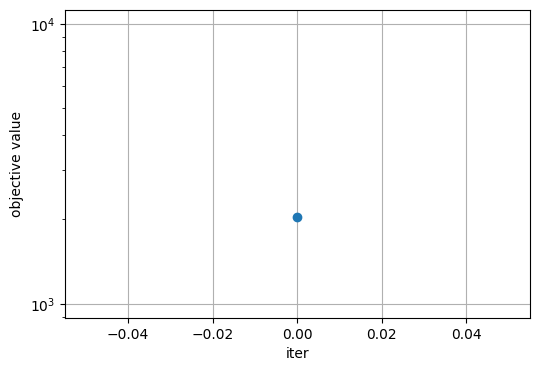

In [29]:
plt.figure(figsize=[6, 4])
plt.xlabel('iter')
plt.ylabel('objective value')
plt.plot(opt_res1.fun, marker='o')
plt.yscale('log')
plt.grid(True)

In [30]:
np.ones(5)

array([1., 1., 1., 1., 1.])